---

# InClass Kaggle Competition - Python - v5.3

The pipeline in this notebook in inspired by the Pipeline code provided my Minh Phan


---

The machine learning pipeline includes:

1. Data processing (Part 2)
- [x] Error correction
- [x] Feature engineering
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling (Part 3)
- [x] Logistic Regression, Random Forest, XGBoost
- [x] Hyper parameter tuning

3. Experimental setup (Part 3)
- [x] k-fold CV
- [x] Oversampling [DROPPED]

4. Debuging (Part 3)
- [x] Analyzing k-fold CV
- [x] Learning curve

## Group #12

##### INDER RANA, NGUYET HAN NGUYEN , ALEKSANDR SHKURIN

In [136]:
%%time
# Version
exp_version = 'v5.3'  # Experiment version
data_prep = 'full'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'lasso'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_full_lasso_v5.3
CPU times: total: 0 ns
Wall time: 0 ns


In [2]:
%cd "C:/Users/irana/OneDrive - IESEG/Documents/GitHub/credit_card_default_predictions"

C:\Users\irana\OneDrive - IESEG\Documents\GitHub\credit_card_default_predictions


In [3]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = False  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = False  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = False  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = False  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = False  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = False  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

CPU times: total: 0 ns
Wall time: 0 ns


## Initiation

In [4]:
%%time
# Data exploration
import matplotlib.pyplot as plt
import plotly.express as px

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline


# Modeling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

CPU times: total: 3.81 s
Wall time: 5.67 s


## 1. Data summary

#### (a) Read and print out some data

In [5]:
%%time
#Group project\Example_v5.3 - Group 2 - Data Processing\data\processed\g2
# Read train, test
train = pd.read_csv("data/raw/credit_default_train.csv", low_memory=False)
test = pd.read_csv('data/raw/credit_default_test.csv', low_memory=False)

CPU times: total: 141 ms
Wall time: 135 ms


In [6]:
%%time
train.columns

CPU times: total: 0 ns
Wall time: 0 ns


Index(['cust_id', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [7]:
%%time
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

float64    23
int64       2
dtype: int64
CPU times: total: 0 ns
Wall time: 4.01 ms


,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,18895,70000.0,1.0,3.0,2.0,34.0,0.0,0.0,0.0,0.0,...,25559.0,26134.0,26715.0,1700.0,1500.0,2000.0,1000.0,1000.0,2000.0,0
1,25102,390000.0,2.0,2.0,2.0,26.0,2.0,2.0,2.0,0.0,...,140387.0,128112.0,115514.0,5000.0,3000.0,5000.0,4548.0,4100.0,3300.0,0
2,28867,60000.0,1.0,1.0,2.0,27.0,0.0,0.0,0.0,0.0,...,26038.0,28607.0,27997.0,1378.0,1406.0,3000.0,3000.0,0.0,923.0,1
3,1842,140000.0,2.0,2.0,1.0,55.0,0.0,0.0,0.0,0.0,...,72391.0,61298.0,62193.0,4200.0,2822.0,2336.0,2588.0,2250.0,2491.0,0
4,3371,50000.0,1.0,1.0,2.0,29.0,2.0,2.0,2.0,0.0,...,1047.0,0.0,0.0,3000.0,0.0,1000.0,0.0,0.0,0.0,1


#### EDA

In [8]:
## try grouping lim balance using qbins

In [9]:
df = pd.DataFrame(train[("default.payment.next.month")].value_counts(normalize=True))

fig = px.bar(x=df.index, y=np.round(df["default.payment.next.month"],2), text_auto=True, height=500, width=600, title="Target Distribution")
fig.show()
#ax

<AxesSubplot:title={'center':'DIstribution of Limit Balance'}, ylabel='Frequency'>

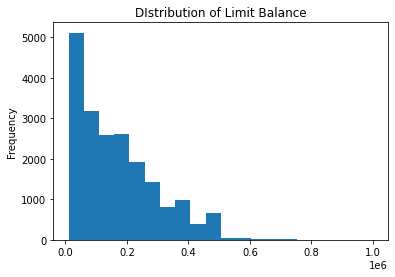

In [10]:
train.LIMIT_BAL.plot.hist(bins=20, title = "DIstribution of Limit Balance")

In [11]:
df = pd.DataFrame(train[("MARRIAGE")].value_counts()).head(2)
fig = px.pie(df, values='MARRIAGE', names=df.index, width=600, height=400, title="MARRIAGE")
fig.show()

In [12]:
df = pd.DataFrame(train[("EDUCATION")].value_counts()).head()
fig = px.pie(df, values='EDUCATION', names=df.index, width=600, height=400, title="Education")
fig.show()

#### (b) Create a list of column names to manage variables

In [13]:
%%time
# General list of variables
id_var = ["cust_id"]  # ID
target_var = ["default.payment.next.month"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['LIMIT_BAL', 'AGE',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

CPU times: total: 0 ns
Wall time: 0 ns


#### (c) Check the target variable class distribution

In [14]:
%%time
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

default.payment.next.month
0                             15586
1                              4414
dtype: int64
default.payment.next.month
0                             0.7793
1                             0.2207
dtype: float64
CPU times: total: 0 ns
Wall time: 10 ms


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [15]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop constant variable: []
CPU times: total: 15.6 ms
Wall time: 20.6 ms


#### (b) Check and correct data error - Missing values

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [16]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 2700
Train - # NA of cat vars: 1748
Test - # NA of num vars: 1443
Test - # NA of cat vars: 916
CPU times: total: 0 ns
Wall time: 0 ns


In [17]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
CPU times: total: 15.6 ms
Wall time: 14.7 ms


In [18]:
%%time
# List dummary variables to track missing values imputation
na_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

CPU times: total: 15.6 ms
Wall time: 22.1 ms


In [20]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

CPU times: total: 203 ms
Wall time: 199 ms


In [21]:
train.head(2)

,cust_id,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,BILL_AMT3_na,BILL_AMT4_na,BILL_AMT5_na,BILL_AMT6_na,PAY_AMT1_na,PAY_AMT2_na,PAY_AMT3_na,PAY_AMT4_na,PAY_AMT5_na,PAY_AMT6_na
0,18895,70000.0,34.0,53972.0,23149.0,23968.0,25559.0,26134.0,26715.0,1700.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25102,390000.0,26.0,185111.0,172865.0,153795.0,140387.0,128112.0,115514.0,5000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### (c) Check and correct data error - Outliers in numerical variables

In [22]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

LIMIT_BAL has # outliers on train, test : 92 [ 0.46 % ] 37 [ 0.37 % ]
AGE has # outliers on train, test : 89 [ 0.44 % ] 51 [ 0.51 % ]
BILL_AMT1 has # outliers on train, test : 458 [ 2.29 % ] 225 [ 2.25 % ]
BILL_AMT2 has # outliers on train, test : 457 [ 2.28 % ] 208 [ 2.08 % ]
BILL_AMT3 has # outliers on train, test : 439 [ 2.2 % ] 220 [ 2.2 % ]
BILL_AMT4 has # outliers on train, test : 454 [ 2.27 % ] 228 [ 2.28 % ]
BILL_AMT5 has # outliers on train, test : 434 [ 2.17 % ] 216 [ 2.16 % ]
BILL_AMT6 has # outliers on train, test : 437 [ 2.18 % ] 212 [ 2.12 % ]
PAY_AMT1 has # outliers on train, test : 284 [ 1.42 % ] 159 [ 1.59 % ]
PAY_AMT2 has # outliers on train, test : 199 [ 1.0 % ] 118 [ 1.18 % ]
PAY_AMT3 has # outliers on train, test : 253 [ 1.26 % ] 111 [ 1.11 % ]
PAY_AMT4 has # outliers on train, test : 266 [ 1.33 % ] 133 [ 1.33 % ]
PAY_AMT5 has # outliers on train, test : 278 [ 1.39 % ] 132 [ 1.32 % ]
PAY_AMT6 has # outliers on train, test : 302 [ 1.51 % ] 131 [ 1.31 % ]
CPU times: 

#### (d) Encode categorical variables

In Python, most of the machine learning libraries will not handle non-numerical values of categorical varibales (e.g. RF). Therefore, we should encoded the categories using integer values.

<u>Note:</u>
- Here, the encoder is fitted on both train and test. Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [23]:
# %%time
# # Keep top 10 categories and combine minor categories into "Others"
# for v in cat_vars:
#     # Find the top 10 categories per cat variable
#     top10_cat = train[v].value_counts()[:10].index.tolist()
#     # Impute on train, test
#     train[v][-train[v].isin(top10_cat)] = 'Others'
#     test[v][-test[v].isin(top10_cat)] = 'Others'

In [24]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars].astype(str), test[cat_vars].astype(str)], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars].astype(str))
test[cat_vars] = enc.transform(test[cat_vars].astype(str))

CPU times: total: 312 ms
Wall time: 316 ms


#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [25]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

CPU times: total: 62.5 ms
Wall time: 58 ms


In [26]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['cust_id']
# num_vars [ 14 ] : ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3'] ...
# cat_vars [ 9 ] : ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2'] ...
# na_vars [ 14 ] : ['LIMIT_BAL_na', 'AGE_na', 'BILL_AMT1_na', 'BILL_AMT2_na', 'BILL_AMT3_na'] ...
# target_var [ 1 ] : ['default.payment.next.month']
CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 39)
(10000, 38)
CPU times: total: 0 ns
Wall time: 10 ms


### 2.2. Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [28]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
AGE    0.007318
Name: default.payment.next.month, dtype: float64
Top 5 vars [-] correlated with target_var :
PAY_AMT5    -0.059715
PAY_AMT2    -0.059855
PAY_AMT4    -0.064028
PAY_AMT1    -0.074582
LIMIT_BAL   -0.145021
Name: default.payment.next.month, dtype: float64
CPU times: total: 31.2 ms
Wall time: 25.8 ms


#### (b) Quickly detect most (potentially) important varriables - Mutual information

<u>Reference:</u>
- Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
- sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [29]:
%%time
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.
mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
PAY_0        0.077603
PAY_2        0.043849
PAY_3        0.036043
PAY_5        0.031838
PAY_4        0.028862
PAY_6        0.027856
EDUCATION    0.004707
SEX          0.001794
MARRIAGE     0.001693
dtype: float64
CPU times: total: 1.16 s
Wall time: 1.28 s


#### (c) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [30]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

CPU times: total: 0 ns
Wall time: 1.05 ms


### 2.3. Value transformation (num, cat => cat)

- Categorical variable: remapping
- Continuous variable: discretization

<u>Note:</u> Some techniques that incoporate the information from target variable may cause overfitting problem.

<u>Reference:</u>

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [31]:
%%time
# List of variables to track the value transformation process
trans_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Test the variable remmaping on a categorical variable

In [32]:
%%time
# Select a cat variable
v = "EDUCATION"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.5366001864486765
Best params: {'min_samples_leaf': 200}
Number of leaves: 5
CPU times: total: 125 ms
Wall time: 3.58 s


In [33]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original categories:", train[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories: 8
# new remapped categories: 5 {1, 4, 5, 7, 8}
CPU times: total: 109 ms
Wall time: 124 ms


#### (b) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [34]:
%%time
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable SEX from 3 to 2 categories
Remapping variable EDUCATION from 8 to 5 categories
Remapping variable MARRIAGE from 5 to 3 categories
Remapping variable PAY_0 from 12 to 7 categories
Remapping variable PAY_2 from 12 to 6 categories
Remapping variable PAY_3 from 12 to 6 categories
Remapping variable PAY_4 from 12 to 6 categories
Remapping variable PAY_5 from 11 to 5 categories
Remapping variable PAY_6 from 11 to 5 categories
CPU times: total: 2.16 s
Wall time: 2.89 s


#### 2.3.2. Discretizing (or binning) numerical variables - Decision tree–based discretization

#### (a) Test the variable discretizing on a numerical variable

In [35]:
%%time
# Select a num variable
v = "PAY_AMT5"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.5806606528606573
Best params: {'min_samples_leaf': 1000}
Number of leaves: 12
CPU times: total: 109 ms
Wall time: 184 ms


In [36]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original data range: ", [train[[v]].min().values[0], train[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 388071.0]
# new remapped categories: 12 {2, 6, 7, 8, 10, 11, 15, 17, 18, 20, 21, 22}
CPU times: total: 62.5 ms
Wall time: 76 ms


#### (b) Apply the variable discretizing for all numerical variables

<u>Note:</u> Only bin/discretize the variables if the number of new categories > 1.

In [37]:
%%time
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.3. Discretizing (or binning) numerical variables - Equal frequency discretization

<u>Note:</u>  
- According to Coussement, Lessmann, & Verstraeten (2017), the number of bins at 10 is optimal. However, we can also test with different values in the range [5, 10].

#### (a) Test the variable discretizing on a numerical variable

In [38]:
%%time
# Select a num variable
v = "AGE"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
CPU times: total: 0 ns
Wall time: 4 ms


array([array([21., 25., 27., 29., 31., 34., 36., 40., 43., 49., 75.])],
      dtype=object)

In [39]:
%%time
# Apply the binning to a variable
binef_v = est.transform(train[[v]])
pd.DataFrame(binef_v).value_counts().sort_index()

CPU times: total: 15.6 ms
Wall time: 6.03 ms


0.0    1807
1.0    1582
2.0    1920
3.0    1986
4.0    2331
5.0    1679
6.0    2645
7.0    1635
8.0    2353
9.0    2062
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [40]:
%%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.4. Discretizing (or binning) numerical variables - Equal width discretization

#### (a) Test the variable discretizing on a numerical variable.

In [41]:
%%time
# Select a variable
v = "AGE"

# Binning values of a variable into new groups using equal width approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
CPU times: total: 0 ns
Wall time: 3 ms


array([array([21. , 26.4, 31.8, 37.2, 42.6, 48. , 53.4, 58.8, 64.2, 69.6, 75. ])],
      dtype=object)

In [42]:
%%time
# Apply the binning to a variable
binew_v = est.transform(train[[v]])
pd.DataFrame(binew_v).value_counts().sort_index()

CPU times: total: 0 ns
Wall time: 7.05 ms


0.0    3389
1.0    4724
2.0    4591
3.0    2881
4.0    2048
5.0    1521
6.0     564
7.0     214
8.0      47
9.0      21
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [43]:
%%time
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            train[binew_var] = est.transform(train[[v]])
            test[binew_var] = est.transform(test[[v]])

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.5. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [44]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 9
CPU times: total: 0 ns
Wall time: 0 ns


In [45]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 48)
(10000, 47)
CPU times: total: 15.6 ms
Wall time: 10 ms


### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding
- Categorical variable: Incidence replacement
- Categorical variable: Weight of Evidence (WoE) conversion

<u>Reference:</u>  

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [46]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.4.1. Dummy coding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

#### (a) Test the value representation on a categorical variable

In [47]:
%%time
# Select a cat variable
v = "EDUCATION"

# Build the dummy encoding on [Var194]
enc = OneHotEncoder(drop="first", handle_unknown="error")
enc.fit(pd.concat([train[[v]], test[[v]]], axis=0))
enc.categories_

CPU times: total: 15.6 ms
Wall time: 8 ms


[array([0., 1., 2., 3., 4., 5., 6., 7.])]

In [48]:
%%time
# Transform a categorical variable
dummy_v = enc.transform(train[[v]])
dummy_v.toarray()

CPU times: total: 0 ns
Wall time: 4 ms


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

#### (b) Apply the value representation for all categorical variables

In [49]:
%%time
# TODO: More efficient implementation
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names_out().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

CPU times: total: 93.8 ms
Wall time: 87 ms


#### 2.4.2. Incidence (of target variable) replacement

#### (a) Test the value representation on a categorical variable

In [50]:
%%time
# Select a variable
v = "EDUCATION"

# Find the incidence rates per category of a categorical variable
tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
tb.columns = [v, v + "_icd"]
tb

CPU times: total: 15.6 ms
Wall time: 8 ms


,EDUCATION,EDUCATION_icd
0,0.0,0.000000
1,1.0,0.195363
2,2.0,0.234895
3,3.0,0.248372
4,4.0,0.038961
5,5.0,0.065217
6,6.0,0.142857
7,7.0,0.236181


In [51]:
%%time
# Add/join the incidence variable
pd.merge(train[[v]], tb, on=v).head()

CPU times: total: 15.6 ms
Wall time: 10 ms


,EDUCATION,EDUCATION_icd
0,3.0,0.248372
1,3.0,0.248372
2,3.0,0.248372
3,3.0,0.248372
4,3.0,0.248372



#### (b) Apply the value representation for all categorical variables

In [52]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]
        test[icd_var] = pd.merge(test[[v]], tb, on=v)[icd_var]

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.4.3. Weight-of-Evidence (WoE) conversion

<u>Note:</u>
- WoE might create +/-Inf value and need to be handled before fitting machine learning model. Here, we correct problem by adding e (small value) to the the numerator and denominator of the WoE equation.

#### (a) Test the value representation on a categorical variable

In [53]:
%%time
# Select a variable
v = "EDUCATION"

# Find the incidence rates per category of a categorical variable
# Add +1 before calculating the log to avoid +/-Inf
tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
e = 1e-10  # Small value
tb[v + "_woe"] = np.log((tb[1] + e) / (tb[0] + e))
tb

CPU times: total: 15.6 ms
Wall time: 6.04 ms


default.payment.next.month,EDUCATION,0,1,EDUCATION_woe
0,0.0,8,0,-25.105292
1,1.0,5622,1365,-1.415533
2,2.0,7104,2181,-1.180875
3,3.0,2424,801,-1.107313
4,4.0,74,3,-3.205453
5,5.0,172,12,-2.662588
6,6.0,30,5,-1.791759
7,7.0,152,47,-1.173733


In [54]:
%%time
# Add/join the WoE variable
pd.merge(train[[v]], tb[[v, v + "_woe"]], on=v).head()

CPU times: total: 15.6 ms
Wall time: 10.8 ms


,EDUCATION,EDUCATION_woe
0,3.0,-1.107313
1,3.0,-1.107313
2,3.0,-1.107313
3,3.0,-1.107313
4,3.0,-1.107313


#### (b) Apply the value representation for all categorical variables

In [55]:
%%time
# TODO: More efficient implementation
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train, test
        train[woe_var] = pd.merge(train[[v]], tb[[v, woe_var]], on=v)[woe_var]
        test[woe_var] = pd.merge(test[[v]], tb[[v, woe_var]], on=v)[woe_var]

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.4.3. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

At the end of this step, all categorical variables were represented by dummy variables or numerical variables. Therefore, it is no need to keep categorical variables.

In [56]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

CPU times: total: 0 ns
Wall time: 4.03 ms


In [57]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

CPU times: total: 46.9 ms
Wall time: 34 ms


#### (b) Impute missing values created by value representation

During the value representation process, if the categorical variables have new categories on test, the represented values might be missing on test data. Therefore, it is necessary to correct again here.

In [58]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

CPU times: total: 93.8 ms
Wall time: 98 ms


#### (c) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [59]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 113
CPU times: total: 0 ns
Wall time: 1.01 ms


In [60]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 143)
(10000, 142)
CPU times: total: 15.6 ms
Wall time: 19 ms


### 2.5. Other data processing

#### (a) Data normalization - Numerical variables

<u>Note:</u>
- It is not necessary to normalize dummy variables since they are in [0, 1].
- With large data set, calling MinMaxScaler().fit() may cause memory issue.

In [61]:
%%time
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

CPU times: total: 953 ms
Wall time: 998 ms


####  (b) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [62]:
%%time
# List of all predictors
predictors = num_vars + cat_vars + na_vars

CPU times: total: 0 ns
Wall time: 0 ns


In [63]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
CPU times: total: 93.8 ms
Wall time: 88 ms



#### (c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [64]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 21
CPU times: total: 5.02 s
Wall time: 5.21 s


In [65]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

CPU times: total: 15.6 ms
Wall time: 20 ms


#### (d) Export the processed data to file

In [66]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(20000, 122)
(10000, 121)
CPU times: total: 0 ns
Wall time: 0 ns


In [141]:
%%time
# Save to pickle format
train.to_pickle("./data/processed/train_processed" + fname + ".pkl")
test.to_pickle("./data/processed/test_processed" + fname + ".pkl")

CPU times: total: 0 ns
Wall time: 0 ns


### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [142]:
%%time
# Read back the processed data
train = pd.read_pickle("./data/processed/train_processed" + fname + ".pkl")
test = pd.read_pickle("./data/processed/test_processed" + fname + ".pkl")

CPU times: total: 31.2 ms
Wall time: 33 ms


In [69]:
%%time
# Create several lists to handle variables
id_var = ['cust_id']
target_var = ['default.payment.next.month']
predictors = [v for v in train.columns if v not in id_var + target_var]

CPU times: total: 0 ns
Wall time: 0 ns


In [70]:
train["Age_sq"] = train.AGE*train.AGE
test["Age_sq"] = test.AGE*test.AGE

predictors = predictors + ['Age_sq']

####  (a) Variable selection: Fisher Score

In [71]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

CPU times: total: 0 ns
Wall time: 0 ns


In [72]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

CPU times: total: 922 ms
Wall time: 646 ms


,predictor,fisherscore
30,PAY_0_4.0,0.488483
41,PAY_2_4.0,0.460187
98,PAY_3_remap_8,0.400939
51,PAY_3_4.0,0.400739
28,PAY_0_2.0,0.385666


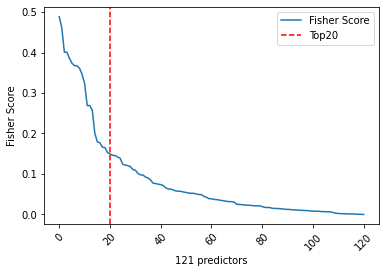

CPU times: total: 141 ms
Wall time: 135 ms


In [73]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

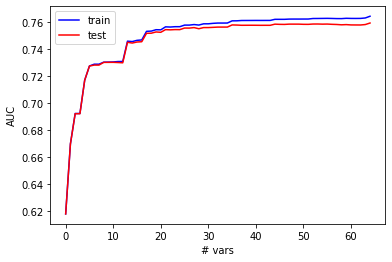

CPU times: total: 2.06 s
Wall time: 42.4 s


In [74]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 65
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [75]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 15  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 15
CPU times: total: 0 ns
Wall time: 1 ms


array(['PAY_0_4.0', 'PAY_2_4.0', 'PAY_3_remap_8', 'PAY_3_4.0',
       'PAY_0_2.0', 'PAY_5_remap_7', 'PAY_4_remap_8', 'PAY_4_4.0',
       'PAY_6_remap_7', 'PAY_5_3.0', 'PAY_6_3.0', 'PAY_2_remap_5',
       'PAY_2_2.0', 'LIMIT_BAL', 'PAY_3_2.0'], dtype=object)

#### (b) Dimensional Reduction: PCA

In [76]:
%%time
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
pca = PCA(n_components=15)
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])
test_pca = pca.transform(test[predictors])

PVE = 0.8673388158530102
CPU times: total: 781 ms
Wall time: 271 ms


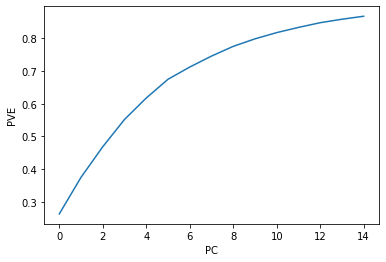

CPU times: total: 156 ms
Wall time: 153 ms


In [77]:
%%time
# Visualize the PVE of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('PVE')
plt.show()

In [78]:
%%time
# Reconstruct the loading vectors
loading_vecs = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_vecs = pd.DataFrame(loading_vecs,
                            columns=['PC' + str(i) for i in list(range(1, pca.n_components_+1))],
                            index=predictors)
loading_vecs.iloc[:2, :2]

CPU times: total: 0 ns
Wall time: 998 µs


,PC1,PC2
LIMIT_BAL,0.018434,-0.035927
AGE,0.013080,-0.001765


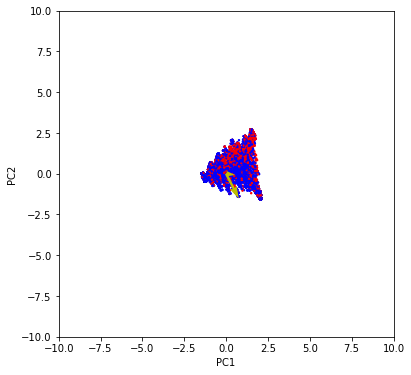

CPU times: total: 719 ms
Wall time: 754 ms


In [79]:
%%time
# Visualize the group of data
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
colors = np.array(['blue'] * len(train[target_var]))
colors[train[target_var].squeeze() == 1] = 'red'
plt.scatter(x=train_pca[:, 0], y=train_pca[:, 1], color=colors, s=2)
plt.quiver([0, 0], [0, 0],
           loading_vecs.iloc[:2, :2]['PC1'].tolist(),
           loading_vecs.iloc[:2, :2]['PC2'].tolist(),
           color=['y','y'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### Lasso

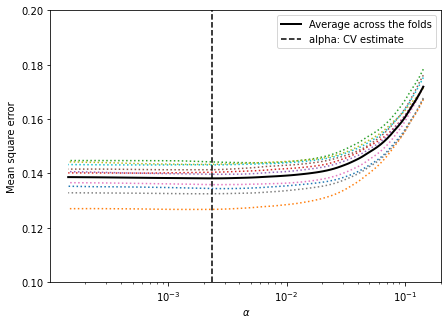

CPU times: total: 21.5 s
Wall time: 13 s


In [80]:
%%time
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html

model = make_pipeline(StandardScaler(), LassoCV(cv=10)).fit(train[predictors],train[target_var].values.ravel())


fig, axes = plt.subplots(figsize = (7, 5))
ymin, ymax = 0.1, 0.2
lasso_cv = model[-1]
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
plt.plot(
lasso_cv.alphas_,
lasso_cv.mse_path_.mean(axis=-1),
color="black",
label="Average across the folds",
linewidth=2,
)
plt.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")



plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.show()

In [81]:
%%time
print(lasso_cv.alpha_)
coefs = lasso_cv.coef_

importance = np.abs(coefs)
lasso = np.array(predictors)[importance > 0]
lasso

0.0023311252571406563
CPU times: total: 15.6 ms
Wall time: 1 ms


array(['LIMIT_BAL', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1.0', 'EDUCATION_2.0',
       'MARRIAGE_1.0', 'MARRIAGE_3.0', 'PAY_0_1.0', 'PAY_0_2.0',
       'PAY_0_3.0', 'PAY_0_4.0', 'PAY_0_5.0', 'PAY_0_10.0', 'PAY_2_3.0',
       'PAY_2_4.0', 'PAY_2_5.0', 'PAY_2_6.0', 'PAY_2_7.0', 'PAY_2_8.0',
       'PAY_3_4.0', 'PAY_3_5.0', 'PAY_3_8.0', 'PAY_3_10.0', 'PAY_3_11.0',
       'PAY_4_1.0', 'PAY_4_3.0', 'PAY_4_6.0', 'PAY_5_1.0', 'PAY_5_3.0',
       'PAY_5_6.0', 'PAY_5_7.0', 'PAY_5_8.0', 'PAY_6_1.0', 'PAY_6_2.0',
       'PAY_6_4.0', 'PAY_6_7.0', 'PAY_6_9.0', 'EDUCATION_remap_7',
       'PAY_0_remap_11', 'PAY_0_remap_12', 'PAY_3_remap_8',
       'PAY_4_remap_8', 'PAY_5_remap_7', 'PAY_6_remap_7', 'AGE_na',
       'BILL_AMT3_na', 'BILL_AMT4_na', 'PAY_AMT3_na', 'PAY_AMT5_na',
       'Age_sq'], dtype='<U17')

In [82]:
# pipeline = Pipeline([
#                      ('scaler',StandardScaler()),
#                      ('model',Lasso())
# ])

# # Optimize the α hyperparameter of Lasso regression
# search = GridSearchCV(pipeline,
#                       {'model__alpha':[1e-4, 1e-3,1e-2, 0.1, 1, 5, 10]},
#                       cv = 5, scoring="neg_mean_squared_error",verbose=3
#                       )
# search.fit(train[predictors],train[target_var])
# search.best_params_

#coefficients = search.best_estimator_.named_steps['model'].coef_
#importance = np.abs(coefficients)
#pd.DataFrame(importance).sort_values(by=0, ascending=False)

In [83]:
# lasso = np.array(predictors)[importance > 1e-03]
# lasso

In [84]:
#np.array(predictors)[importance <= 1e-03]

## 3. Modeling

<u>Note:</u>
- Mass feature engineering may lead to overfitting. Especially with the techniques that link information from the target variable to the predictors (including Fisher Score for variable selection).
- Therefore, the k-fold cross-validation in below is convenient to use, but is not a 100% correct method to estimate the performance of the models. Train, validation and test set should be processed separately to avoid information leakage.

<u>Reference:</u>  

- Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 

In [85]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

CPU times: total: 0 ns
Wall time: 0 ns


In [86]:
#fs_plus = top_fs_vars + ['LIMIT_BAL', 'AGE','Age_sq']

In [87]:
# Prepare the data, select the variable set
var_set = 'lasso'  # all = all vars, fs = top fisher score, pca = first PCs
if var_set == 'all':
    X = train[predictors]
    X_test = test[predictors]
    test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    #X = train[fs_plus]
    #X_test = test[fs_plus]
    X_test = test[top_fs_vars]
    test_id = test[id_var]
elif var_set == 'pca':
    X = train_pca
    X_test = test_pca
    test_id = test[id_var]
elif var_set == 'lasso':
    X = train[lasso]
    X_test = test[lasso]
    test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(20000, 55)
_full_lasso55_v5.3


### 3.1. Modeling

In [109]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification

#### a) Isolation Forest

Isolation Forest: We tried to check if the there are some anomilies in the patern. To understand if there are some exceptional cases where a good customer may not pay his credit card bill on time.
<br>
Reference: https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [110]:
import shutup
shutup.please()
X_train, y_train = X, y

clf = IsolationForest(random_state=47)

param_grid = {'n_estimators': [20, 100], 
              'max_samples': [20, 100], 
              'contamination': [0.1, 0.3], 
              'max_features': [5,10], 
              'bootstrap': [True, False], 
              'n_jobs': [-1]}

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring='roc_auc', 
                                                 verbose=10,
                                                 refit=True,
                                                 cv=10,
                                                 return_train_score=True)
grid_dt_estimator.fit(X, y)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10; 1/32] START bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=20, n_jobs=-1
[CV 1/10; 1/32] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=20, n_jobs=-1;, score=(train=0.375, test=0.370) total time=   0.4s
[CV 2/10; 1/32] START bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=20, n_jobs=-1
[CV 2/10; 1/32] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=20, n_jobs=-1;, score=(train=0.377, test=0.358) total time=   0.1s
[CV 3/10; 1/32] START bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=20, n_jobs=-1
[CV 3/10; 1/32] END bootstrap=True, contamination=0.1, max_features=5, max_samples=20, n_estimators=20, n_jobs=-1;, score=(train=0.383, test=0.406) total time=   0.1s
[CV 4/10; 1/32] START bootstrap=True, contamination=0.1, max_features=5, max_samples=20,

GridSearchCV(cv=10, estimator=IsolationForest(random_state=47),
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.1, 0.3], 'max_features': [5, 10],
                         'max_samples': [20, 100], 'n_estimators': [20, 100],
                         'n_jobs': [-1]},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [115]:
print("Best parameters: ",grid_dt_estimator.best_params_)
print('Best AUC train:', max(list(grid_dt_estimator.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(grid_dt_estimator.cv_results_['mean_test_score'])))

Best parameters:  {'bootstrap': True, 'contamination': 0.1, 'max_features': 10, 'max_samples': 20, 'n_estimators': 20, 'n_jobs': -1}
Best AUC train: 0.3980729036043765
Best AUC test: 0.39667852791572233


##### b) Random Forest

In [270]:
%%time
# Random Forest
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
rf = RandomForestClassifier(random_state=1)

tuned_parameters = {
'n_estimators':[250, 500, 750],
'criterion' : ["gini"], #"entrophy"
'max_features':["auto", "log2"]
}

clf = GridSearchCV(rf, tuned_parameters, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=10, return_train_score=True)

clf.fit(X, y)

model_grid['rf'] = clf

print("Best parameters: ",clf.best_params_)
print('Best AUC train:', max(list(clf.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(clf.cv_results_['mean_test_score'])))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:  {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 750}
Best AUC train: 0.9999880692358767
Best AUC test: 0.7596721595252175
CPU times: total: 37.7 s
Wall time: 4min 55s


#### c) CatBoost

In [127]:
%%time
from catboost import CatBoostClassifier

train_data = X
train_labels = y

model = CatBoostClassifier(verbose=0, learning_rate=0.009, depth=16, random_state=1)

cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

grid = {'num_trees': [50]}

grid_dt_estimator = model_selection.GridSearchCV(model, 
                                                 grid,
                                                 scoring='roc_auc', 
                                                 refit=True,
                                                 verbose=10,
                                                 cv=cv,
                                                 return_train_score=True)
grid_dt_estimator.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START num_trees=50................................................
[CV 1/5; 1/1] END num_trees=50;, score=(train=0.877, test=0.756) total time= 3.2min
[CV 2/5; 1/1] START num_trees=50................................................
[CV 2/5; 1/1] END num_trees=50;, score=(train=0.872, test=0.756) total time= 3.0min
[CV 3/5; 1/1] START num_trees=50................................................
[CV 3/5; 1/1] END num_trees=50;, score=(train=0.875, test=0.773) total time= 2.9min
[CV 4/5; 1/1] START num_trees=50................................................
[CV 4/5; 1/1] END num_trees=50;, score=(train=0.869, test=0.774) total time= 2.7min
[CV 5/5; 1/1] START num_trees=50................................................
[CV 5/5; 1/1] END num_trees=50;, score=(train=0.867, test=0.783) total time= 2.9min
CPU times: total: 1h 10min 9s
Wall time: 17min 35s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x00000235151790A0>,
             param_grid={'num_trees': [50]}, return_train_score=True,
             scoring='roc_auc', verbose=10)

In [128]:
print("Best parameters: ",grid_dt_estimator.best_params_)
print('Best AUC train:', max(list(grid_dt_estimator.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(grid_dt_estimator.cv_results_['mean_test_score'])))

Best parameters:  {'num_trees': 50}
Best AUC train: 0.8720641671214985
Best AUC test: 0.7681082918746702


In [117]:
cat = CatBoostClassifier(verbose=0, learning_rate=0.009, depth=16, num_trees=50, random_state=1)
cat.fit(X, y)

In [135]:
cat_proba = cat.predict_proba(X_test)

In [148]:
cat_out = test[["cust_id"]]
cat_out["default.payment.next.month"] = pd.DataFrame(cat_proba)[[1]]

In [150]:
cat_out.to_csv("cat.csv")

#### d) MLP

In [99]:
%%time
mlp_gs = MLPClassifier(max_iter=100)

cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(40,50,10), (40,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.03, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf_nn = GridSearchCV(mlp_gs,
                        parameter_space,
                        n_jobs=-1,
                        scoring='roc_auc', 
                        refit=True,
                        verbose=10,
                        cv=cv,
                        return_train_score=True)
clf_nn.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 50.6 s
Wall time: 12min 25s


C:\tools\Anaconda3\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'], 'alpha': [0.03, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (40, 50, 10),
                                                (40,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [101]:
print("Best parameters: ",clf_nn.best_params_)
print('Best AUC train:', max(list(clf_nn.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(clf_nn.cv_results_['mean_test_score'])))

Best parameters:  {'activation': 'tanh', 'alpha': 0.03, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}
Best AUC train: 0.8405977545265442
Best AUC test: 0.7672195086630997


In [116]:
nn_out = test[["cust_id"]]
nn_out[target_var] = pd.DataFrame(clf_nn.predict_proba(X_test))[[1]]
nn_out.to_csv('nn_out.csv', index=False)

C:\tools\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### e) Logistic Regression

In [200]:
%%time
# Logistic regression
# Tune parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
tuned_parameters = {'penalty': ['l1'],
                'solver': ['liblinear'],
              'C': [0.01, 0.1, 0.5, 1, 2],
              'max_iter': [500, 1000, 1500]}
lr = LogisticRegression(max_iter=500, class_weight='balanced') 
clf = GridSearchCV(lr, tuned_parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 2.67 s
Wall time: 18.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=500),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2],
                         'max_iter': [500, 1000, 1500], 'penalty': ['l1'],
                         'solver': ['liblinear']},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [201]:
print("Best parameters: ",clf.best_params_)
print('Best AUC train:', max(list(clf.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(clf.cv_results_['mean_test_score'])))

Best parameters:  {'C': 2, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUC train: 0.7690472259167681
Best AUC test: 0.7631359521832906


In [213]:
%%time
# Logistic regression
# Tune parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
tuned_parameters = {'penalty': ['l2'],
                'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
              'C': [2, 1.5],
              'max_iter': [1500, 1300, 1400]}
lr = LogisticRegression(max_iter=500, class_weight='balanced') 
clf = GridSearchCV(lr, tuned_parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: total: 1.81 s
Wall time: 37.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=500),
             n_jobs=-1,
             param_grid={'C': [2, 1.5], 'max_iter': [1500, 1300, 1400],
                         'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [214]:
print("Best parameters: ",clf.best_params_)
print('Best AUC train:', max(list(clf.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(clf.cv_results_['mean_test_score'])))

Best parameters:  {'C': 2, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'sag'}
Best AUC train: 0.7676695463716465
Best AUC test: 0.7620706088673466


In [ ]:
%%time
# Logistic regression
# Tune parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
tuned_parameters = {'penalty': ['l2'],
                'solver': ['newton-cg'],
              'C': [0.01, 0.1, 0.5, 1, 2],
              'max_iter': [500, 1000, 1500]}
lr = LogisticRegression(max_iter=500, class_weight='balanced') 
clf = GridSearchCV(lr, tuned_parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)

print("Best parameters: ",clf.best_params_)
print('Best AUC train:', max(list(clf.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(clf.cv_results_['mean_test_score'])))

### f) LDA

In [101]:
%%time
# LDA
# Find the best parameters
#cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
tuned_parameters = {}
lda = LinearDiscriminantAnalysis()
clf = GridSearchCV(lda, tuned_parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=10, return_train_score=True)
clf.fit(X, y)
print("Best parameters: ",clf.best_params_)
print('Best AUC train:', max(list(clf.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(clf.cv_results_['mean_test_score'])))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {}
Best AUC train: 0.7459802003071078
Best AUC test: 0.7446459101713095
CPU times: total: 125 ms
Wall time: 318 ms


#### g) LGBM

In [118]:
%%time
# Gradient Boosting
# Find the best parameters
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
gb = LGBMClassifier(random_state=1)
tuned_parameters = {
    'boosting_type': ['dart','gbdt','rf'],
    'objective': ['binary'],
    'learning_rate': [0.05,0.3, 0.1],
    'num_leaves': [10, 6],
    'max_depth': [3, 4],
    'reg_alpha': [0.5],
    'reg_lambda': [1.2, 1.5],
    'n_estimators':[100, 350]
}
clf = GridSearchCV(gb, tuned_parameters, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=10, return_train_score=True, refit=True)
clf.fit(X, y)
model_grid['gb'] = clf  
print("Best parameters: ",clf.best_params_)
print('Best AUC train:', max(list(clf.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(clf.cv_results_['mean_test_score'])))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters:  {'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 350, 'num_leaves': 10, 'objective': 'binary', 'reg_alpha': 0.5, 'reg_lambda': 1.2}
Best AUC train: 0.8447827040932918
Best AUC test: 0.7752910652476861
CPU times: total: 21.9 s
Wall time: 3min 35s


In [119]:
# Make prediction using the best model
gbr_pred = model_grid['gb'].best_estimator_.predict_proba(X_test)

#### h) AdaBoost

In [271]:
ada = AdaBoostClassifier(base_estimator=RandomForestClassifier())

parameters = {'max_depth':[i for i in range(2,11,4)],
              'min_samples_leaf':[5,10],
              'n_estimators':[250],
              'learning_rate':[0.01,0.1]}

ada_gs = GridSearchCV(ada, parameters, scoring='roc_auc', n_jobs=-1, cv=5, verbose=10, return_train_score=True)

In [123]:
ada_gs.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [1]:
model_grid['gb_ada'] = ada_gs  
print("Best parameters: ",ada_gs.best_params_)
print('Best AUC train:', max(list(ada_gs.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(ada_gs.cv_results_['mean_test_score'])))

Best parameters:  {'max_depth': '4', 'min_samples_leaf': 5, 'n_estimators': 250, 'learning_rate': 0.01,}
Best AUC train: 0.8290350332489794
Best AUC test: 0.7755229638947044
CPU times: total: 129 ms
Wall time: 230 ms


In [ ]:
#AdaBoostClassifier(base_estimator=RandomForestClassifier(), max_depth=4, min_samples_leaf=5, n_estimators=250, learning_rate=0.01)

#### i) XGBoost

In [103]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.008, 0.007, 0.005], #so called `eta` value
              'max_depth': [20, 30],
              'min_child_weight': [11, 20],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7, 0.5, .09],
              'n_estimators': [5, 10, 20], #number of trees, change it to 1000 for better results
              'seed': [1, 2, 4]}


xgb_model = XGBClassifier(use_label_encoder=False)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

xgb = GridSearchCV(xgb_model, parameters, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=10, refit=True, return_train_score=True)
xgb.fit(X, y)

model_grid['xgb'] = xgb

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[00:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [104]:
model_grid['xgb'] = xgb  
print("Best parameters: ",xgb.best_params_)
print('Best AUC train:', max(list(xgb.cv_results_['mean_train_score'])))
print('Best AUC test:', max(list(xgb.cv_results_['mean_test_score'])))

Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.007, 'max_depth': 20, 'min_child_weight': 20, 'n_estimators': 20, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 4, 'silent': 1, 'subsample': 0.8}
Best AUC train: 0.8304844252556519
Best AUC test: 0.773772039558625


* Reference https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

In [105]:
%%time
model = XGBClassifier(use_label_encoder=False)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=10, return_train_score=True)
grid_result = grid_search.fit(X, y)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[00:36:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 13.9 s
Wall time: 2min 27s


Best: -0.434476 using {'learning_rate': 0.1}
-0.688716 (0.000079) with: {'learning_rate': 0.0001}
-0.652439 (0.000685) with: {'learning_rate': 0.001}
-0.485463 (0.004194) with: {'learning_rate': 0.01}
-0.434476 (0.007937) with: {'learning_rate': 0.1}
-0.442636 (0.008260) with: {'learning_rate': 0.2}
-0.453978 (0.010465) with: {'learning_rate': 0.3}


Text(0, 0.5, 'Log Loss')

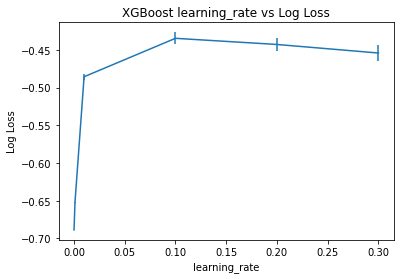

In [112]:
from matplotlib import pyplot
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(learning_rate, means, yerr=stds)
pyplot.title("XGBoost learning_rate vs Log Loss")
pyplot.xlabel('learning_rate')
pyplot.ylabel('Log Loss')

In [113]:
%%time
model = XGBClassifier(use_label_encoder=False)
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=10)
grid_result = grid_search.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[01:04:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 55.5 s
Wall time: 23min 2s


Best: -0.431988 using {'learning_rate': 0.01, 'n_estimators': 500}
-0.688698 (0.000092) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.684335 (0.000182) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.680059 (0.000270) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.675862 (0.000353) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.671746 (0.000435) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.652305 (0.000812) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.618509 (0.001380) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.590395 (0.001842) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.566840 (0.002259) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.547013 (0.002694) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.485022 (0.004376) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.444378 (0.005892) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.434425 (0.006632) with: {'learning_rate': 0.01, 'n_

Text(0, 0.5, 'Log Loss')

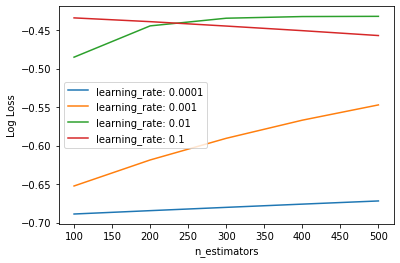

In [172]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')

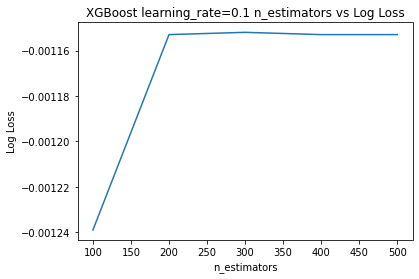

In [173]:
# Plot performance for learning_rate=0.1
from matplotlib import pyplot
n_estimators = [100, 200, 300, 400, 500]
loss = [-0.001239, -0.001153, -0.001152, -0.001153, -0.001153]
pyplot.plot(n_estimators, loss)
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost learning_rate=0.1 n_estimators vs Log Loss')
pyplot.show()

In [115]:
xg_t = XGBClassifier(learning_rate=0.10, n_estimators=250, use_label_encoder=False)
xg_t.fit(X,y)

[01:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [116]:
score = xg_t.score(X, y)

In [120]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns,
    class_names=[1, 0],
    mode='classification'
)

In [129]:
y

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [133]:
exp = explainer.explain_instance(
    data_row=X.iloc[1], 
    predict_fn=xg_t.predict_proba
)

exp.show_in_notebook(show_table=True)

In [182]:
xgt_proba = xg_t.predict_proba(X_test)
xgt_out = test[["cust_id"]]
xgt_out[target_var] = pd.DataFrame(xgt_proba)[1]
xgt_out.to_csv("xgt_out.csv", index=False)
xgt_out.head()

C:\Users\irana\AppData\Local\Temp\ipykernel_21132\1417959714.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\tools\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cust_id,default.payment.next.month
0,18847,0.194830
1,26803,0.118060
2,2986,0.424238
3,25718,0.231389
4,29710,0.039691


### 3.2. Stacking & Voting ensemble

<u>Reference:</u>
- Ensemble methods. Link: https://scikit-learn.org/stable/modules/ensemble

In [243]:
stack1 = test[["cust_id"]]
stack1[target_var] = pd.DataFrame(xgt_proba)[[1]] + pd.DataFrame(gbr_pred)[[1]]/2
stack1.to_csv("stack1.csv", index=False)
stack1.head()

C:\tools\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cust_id,default.payment.next.month
0,18847,0.375029
1,26803,0.181627
2,2986,0.615035
3,25718,0.330012
4,29710,0.196267


In [203]:
test[["cust_id","target"]].to_csv("cust.csv")

### 3.2.1 Auto ML

In [235]:
import h2o
from h2o.automl import H2OAutoML

In [382]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 8 mins
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.4
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_irana_egbm9e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.795 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [534]:
HX = X
HX['target'] = y

hdf =  h2o.H2OFrame(HX)
#############################################################################

C:\Users\irana\AppData\Local\Temp\ipykernel_5728\4291578245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HX['target'] = y


In [539]:
pred = ['PAY_0_4.0', 'PAY_2_4.0', 'PAY_3_4.0', 'PAY_0_2.0', 'PAY_4_4.0', 'PAY_5_3.0', 'PAY_6_3.0', 'PAY_2_2.0', 'LIMIT_BAL', 'AGE']

In [540]:
train_h,test_h = hdf.split_frame(ratios=[.8])

In [541]:
# Identify predictors and response
x = pred
y = 'target'

In [543]:
# For binary classification, response should be a factor
train_h[y] = train_h[y].asfactor()
train_h[y] = train_h[y].asfactor()

modlist = ["GLM", "DRF", "GBM", "DeepLearning", "StackedEnsemble", "XGBoost"]

# Run AutoML for 20 base models
aml = H2OAutoML(seed=42, include_algos=modlist, sort_metric='AUC')
aml.train(x=x, y=y, training_frame=train_h)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
#################################################################################

AutoML progress: |█
23:01:53.295: AutoML: XGBoost is not available; skipping it.
23:01:53.301: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:01:53.301: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_7_AutoML_2_20220408_230153,0.746579,0.446695,0.509739,0.309937,0.374879,0.140534
StackedEnsemble_AllModels_4_AutoML_2_20220408_230153,0.746244,0.446692,0.511543,0.309886,0.374885,0.140538
StackedEnsemble_Best1000_1_AutoML_2_20220408_230153,0.746182,0.446793,0.511133,0.312284,0.374908,0.140556
StackedEnsemble_BestOfFamily_6_AutoML_2_20220408_230153,0.746119,0.447355,0.511786,0.31187,0.375168,0.140751
GBM_grid_1_AutoML_2_20220408_230153_model_63,0.746027,0.446849,0.510643,0.310521,0.374863,0.140522
GBM_grid_1_AutoML_2_20220408_230153_model_67,0.745837,0.447389,0.510673,0.307751,0.375155,0.140741
StackedEnsemble_AllModels_6_AutoML_2_20220408_230153,0.745822,0.446905,0.510131,0.311491,0.37496,0.140595
StackedEnsemble_AllModels_3_AutoML_2_20220408_230153,0.745753,0.447155,0.511076,0.31255,0.375096,0.140697
GBM_grid_1_AutoML_2_20220408_230153_model_49,0.745739,0.447416,0.509524,0.309602,0.375209,0.140782
StackedEnsemble_BestOfFamily_4_AutoML_2_20220408_230153,0.745688,0.447265,0.511831,0.31322,0.375139,0.140729


In [544]:
#xgb = aml.get_best_model(algorithm="xgboost")

#preds = aml.predict(test)
preds = aml.leader.predict(test_h[pred])

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [547]:
perf = aml.leader.model_performance(test_h[pred + ['target']])

In [548]:
perf.auc


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.13781824637903897
RMSE: 0.3712387996681368
LogLoss: 0.440891685353841
Null degrees of freedom: 3958
Residual degrees of freedom: 3954
Null deviance: 4202.466920897026
Residual deviance: 3490.9803646317127
AIC: 3500.9803646317127
AUC: 0.7542288450974703
AUCPR: 0.5398910964402345
Gini: 0.5084576901949407

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30760982090271805: 


,,0,1,Error,Rate
0,0,2758.0,318.0,0.1034,(318.0/3076.0)
1,1,451.0,432.0,0.5108,(451.0/883.0)
2,Total,3209.0,750.0,0.1942,(769.0/3959.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.307610,0.529088,196.0
1,max f2,0.124539,0.618693,333.0
2,max f0point5,0.451340,0.593165,143.0
3,max accuracy,0.469121,0.823188,136.0
4,max precision,0.856792,1.000000,0.0
5,max recall,0.048957,1.000000,399.0
6,max specificity,0.856792,1.000000,0.0
7,max absolute_mcc,0.442314,0.425528,145.0
8,max min_per_class_accuracy,0.168190,0.678369,278.0
9,max mean_per_class_accuracy,0.235503,0.698391,230.0



Gains/Lift Table: Avg response rate: 22.30 %, avg score: 22.54 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010104,0.795618,3.811042,3.811042,0.850000,0.812615,0.850000,0.812615,0.038505,0.038505,281.104190,281.104190,0.036555
1,2,0.020207,0.765386,3.250595,3.530818,0.725000,0.784848,0.787500,0.798731,0.032843,0.071348,225.059456,253.081823,0.065821
2,3,0.030058,0.721453,3.448907,3.503973,0.769231,0.746340,0.781513,0.781561,0.033975,0.105323,244.890670,250.397328,0.096870
3,4,0.040162,0.695573,3.250595,3.440230,0.725000,0.706842,0.767296,0.762764,0.032843,0.138165,225.059456,244.023020,0.126137
4,5,0.050265,0.667960,3.138505,3.379582,0.700000,0.679899,0.753769,0.746108,0.031710,0.169875,213.850510,237.958194,0.153946
5,6,0.100025,0.575306,2.822151,3.102274,0.629442,0.624408,0.691919,0.685565,0.140430,0.310306,182.215107,210.227416,0.270644
6,7,0.150038,0.412292,2.332367,2.845638,0.520202,0.492023,0.634680,0.621051,0.116648,0.426954,133.236670,184.563834,0.356407
7,8,0.200051,0.287957,1.426593,2.490877,0.318182,0.340424,0.555556,0.550894,0.071348,0.498301,42.659323,149.087706,0.383867
8,9,0.300581,0.191398,1.002609,1.993120,0.223618,0.227506,0.444538,0.442736,0.100793,0.599094,0.260931,99.312028,0.384205
9,10,0.400606,0.167722,0.803874,1.696184,0.179293,0.178165,0.378310,0.376677,0.080408,0.679502,-19.612604,69.618362,0.358956


<bound method MetricsBase.auc of >

In [349]:
test_h = h2o.H2OFrame(test[pred])
preds_test = aml.leader.predict(test_h)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [372]:
pred_df = preds_test.as_data_frame()
pred_df.shape

(10000, 3)

In [374]:
test_h = test
test_h['p0'] = pred_df['p0']
test_h['p1'] = pred_df['p1']
test_h['predict'] = pred_df['predict']

In [377]:
test_h[["cust_id","p0","p1","predict"]].to_csv("h_sub.csv", index=False)

### Voting

In [157]:
#https://www.geeksforgeeks.org/ensemble-methods-in-python/
LGBM = LGBMClassifier(boosting_type='gbdt', random_state=1, learning_rate= 0.1, max_depth= 5, num_leaves= 10, objective = 'binary', reg_alpha= 0.8, reg_lambda= 1)
#XBG = xgboost.XGBClassifier(colsample_bytree= 0.7, learning_rate= 0.005, max_depth= 20, min_child_weight= 20, n_estimators= 20, nthread= 4, objective= 'binary:logistic', seed= 1, silent= 1, subsample= 0.8, use_label_encoder=False)
RF = RandomForestClassifier(n_estimators=300)
CAT = CatBoostClassifier(verbose=0, learning_rate=0.009, depth=16)
LR = LogisticRegression()


final_model = VotingClassifier(
    estimators=[('LGBM', LGBM),('RF', RF), ('CAT', CAT), ('LR', LR)], voting='soft') # we keep voting type as soft because we need raw probabilities instead of classes

final_model.fit(X, y)

VotingClassifier(estimators=[('LGB',
                              LGBMClassifier(max_depth=5, num_leaves=10,
                                             objective='binary', random_state=1,
                                             reg_alpha=0.8, reg_lambda=1)),
                             ('MLP', RandomForestClassifier(n_estimators=300)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000025F88579FA0>)],
                 voting='soft')

In [163]:
pred_final = final_model.predict_proba(X_test)

In [164]:
vot = test[["cust_id"]]
vot[target_var] = pd.DataFrame(pred_final)[1]
vot.to_csv('vot3.csv', index=False)
vot.head()

C:\Users\irana\AppData\Local\Temp\ipykernel_21132\892937793.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\tools\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cust_id,default.payment.next.month
0,18847,0.463935
1,26803,0.123614
2,2986,0.308393
3,25718,0.178302
4,29710,0.231486


In [ ]:
#https://www.geeksforgeeks.org/ensemble-methods-in-python/
LGBM = LGBMClassifier(boosting_type='gbdt', random_state=1, learning_rate= 0.1, max_depth= 5, num_leaves= 10, objective = 'binary', reg_alpha= 0.8, reg_lambda= 1)
RF = RandomForestClassifier(criterion= 'gini', max_features= 'log2', n_estimators = 750)
CAT = CatBoostClassifier(verbose=0, learning_rate=0.009, depth=16)
LR = LogisticRegression(C= 2, max_iter= 1000, penalty= 'l1', solver= 'liblinear')

final_model_tuned = VotingClassifier(
estimators=[('LGBM', LGBM),('RF', RF), ('CAT', CAT), ('LR', LR)], voting='soft') # we keep voting type as soft because we need raw probabilities instead of classes


final_model_tuned.fit(X, y)

In [ ]:
final_model_tuned.predict_proba(X_test)